This Notebook is based on the book *Python Machine Learning 2nd Edition* by [Sebastian Raschka](https://sebastianraschka.com), Packt Publishing Ltd. 2017, following Chapter 12.

Code Repository: https://github.com/rasbt/python-machine-learning-book-2nd-edition

Code License: [MIT License](https://github.com/rasbt/python-machine-learning-book-2nd-edition/blob/master/LICENSE.txt)

# Implementing a Multi-layer Artificial Neural Network from Scratch


### Recap: Single-layer neural network

This chapter is all about multilayer neural networks, how they work, and how
to train them to solve complex problems. However, before we dig deeper into a
particular multilayer neural network architecture, let's briefly reiterate some of the
concepts of single-layer neural networks that we introduced in Chapter 2, Training
Simple Machine Learning Algorithms for Classification, namely, the **ADAptive LInear
NEuron (Adaline) algorithm**, which is shown in the following figure:

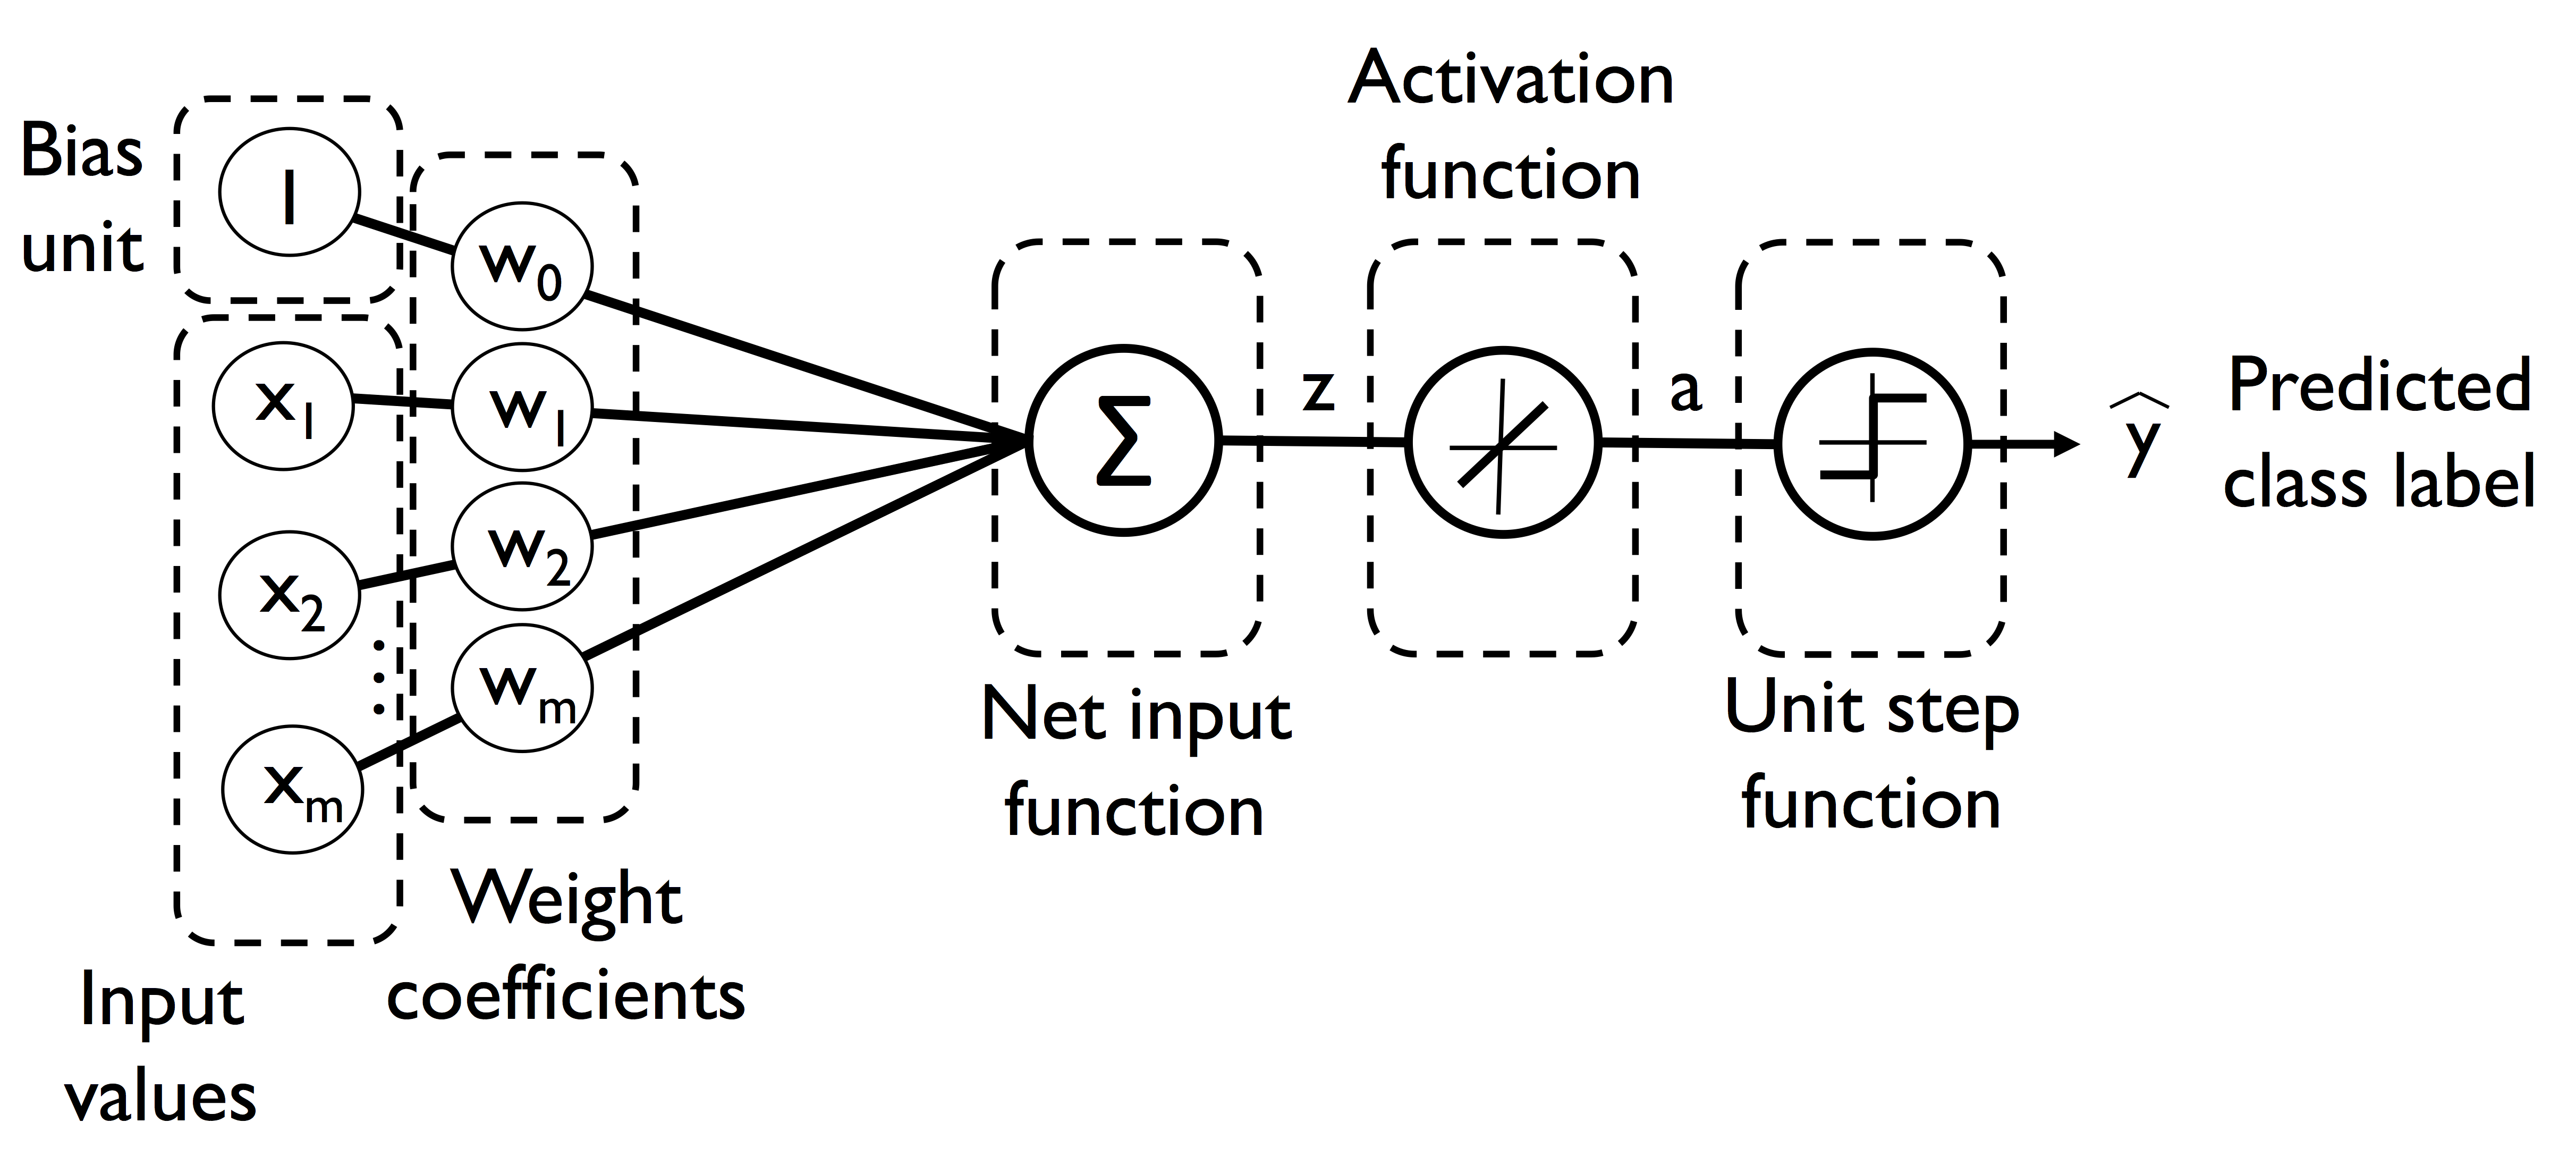

In [1]:
from IPython.display import Image
%matplotlib inline

Image(filename='images/12_01.png', width=600) 

<br>
<br>

The **Adaline algorithm** can perform binary classification. A classical approach to to learn the weight coefficients of the model is the **gradient descent optimization** algorithm. It works as follws: In every epoch (pass over the training set), the weight vector $\mathbf{w}$ is updated using the following update rule:

$$ \mathbf{w} := \mathbf{w} + \Delta \mathbf{w}\text{, where }\Delta \mathbf{w} = - \eta \nabla J(\mathbf{w}) $$

- the gradient is computed based on the whole training set 
- the weights of the model are updated by taking a step into the opposite direction of thegradient $\nabla J (\mathbf{w})$.

In order to find the optimal weights of the model, we can optimize an
objective function that we define as **the Sum of Squared Errors (SSE) cost function J (w)**. 
Furthermore, we multiplied the gradient $\nabla J (\mathbf{w})$ by a factor, the **learning rate $ \eta $**,
which we have to choose carefully to balance the speed of learning against the risk of overshooting the global minimum of the cost function.

In gradient descent optimization, we update all weights simultaneously after each epoch, and we define the partial derivative for each weight $w_j$ in the weight vector $\mathbf{w}$ as follows:

 $$ \frac{\partial}{\partial w_j} J(\mathbf{w}) = - \sum_i \left( y^{(i)} - a^{(i)}\right) x_j{(i)} $$

- $y^{(i)}$ is the target class label of a particular sample $x^{(i)}$ 
- $a^{(i)}$  is the activation of the neuron, which is a linear function in the special case of Adaline. 
- the activation function $\phi (z)$ is as follows:

 $$\phi (z) = z = a$$
 
Here, the net input $z$ is a linear combination of the weights that are connecting the input to the output layer:

$$z = \sum_j w_j x_j =  \mathbf{w}^T \mathbf{x}$$

While we use the activation $\phi (z)$ to compute the gradient update, we implement a threshold function to squash the continuous valued output into binary class labels
for prediction:
$$ \hat{y} =  \begin{cases}  1 & \text{if }g(z) \neq 0 \\ -1 & \text{otherwise} \end{cases}
 $$.

There is a certain trick to accelerate the model learning, the so-called **stochastic gradient descent optimization**. Stochastic gradient descent approximates the cost from a single training sample (online learning) or a small subset of training samples (mini-batch learning). We will make use of this concept later in this chapter
when we implement and train a multilayer perceptron. Apart from faster learning— due to the more frequent weight updates compared to gradient descent—its noisy nature is also regarded as beneficial when training multilayer neural networks with non-linear activation functions, which do not have a convex cost function. Here, the added noise can help to escape local cost minima, but we will discuss this topic in more detail later in this chapter.


## Recap: the multi-layer neural network architecture

A classical way is to connect **multiple single neurons to a multilayer feedforward neural network**; this special type of fully connected network is also called feed forward **Multilayer Perceptron (MLP)**. The following figure illustrates the concept of such an an MLP consisting of three layers:

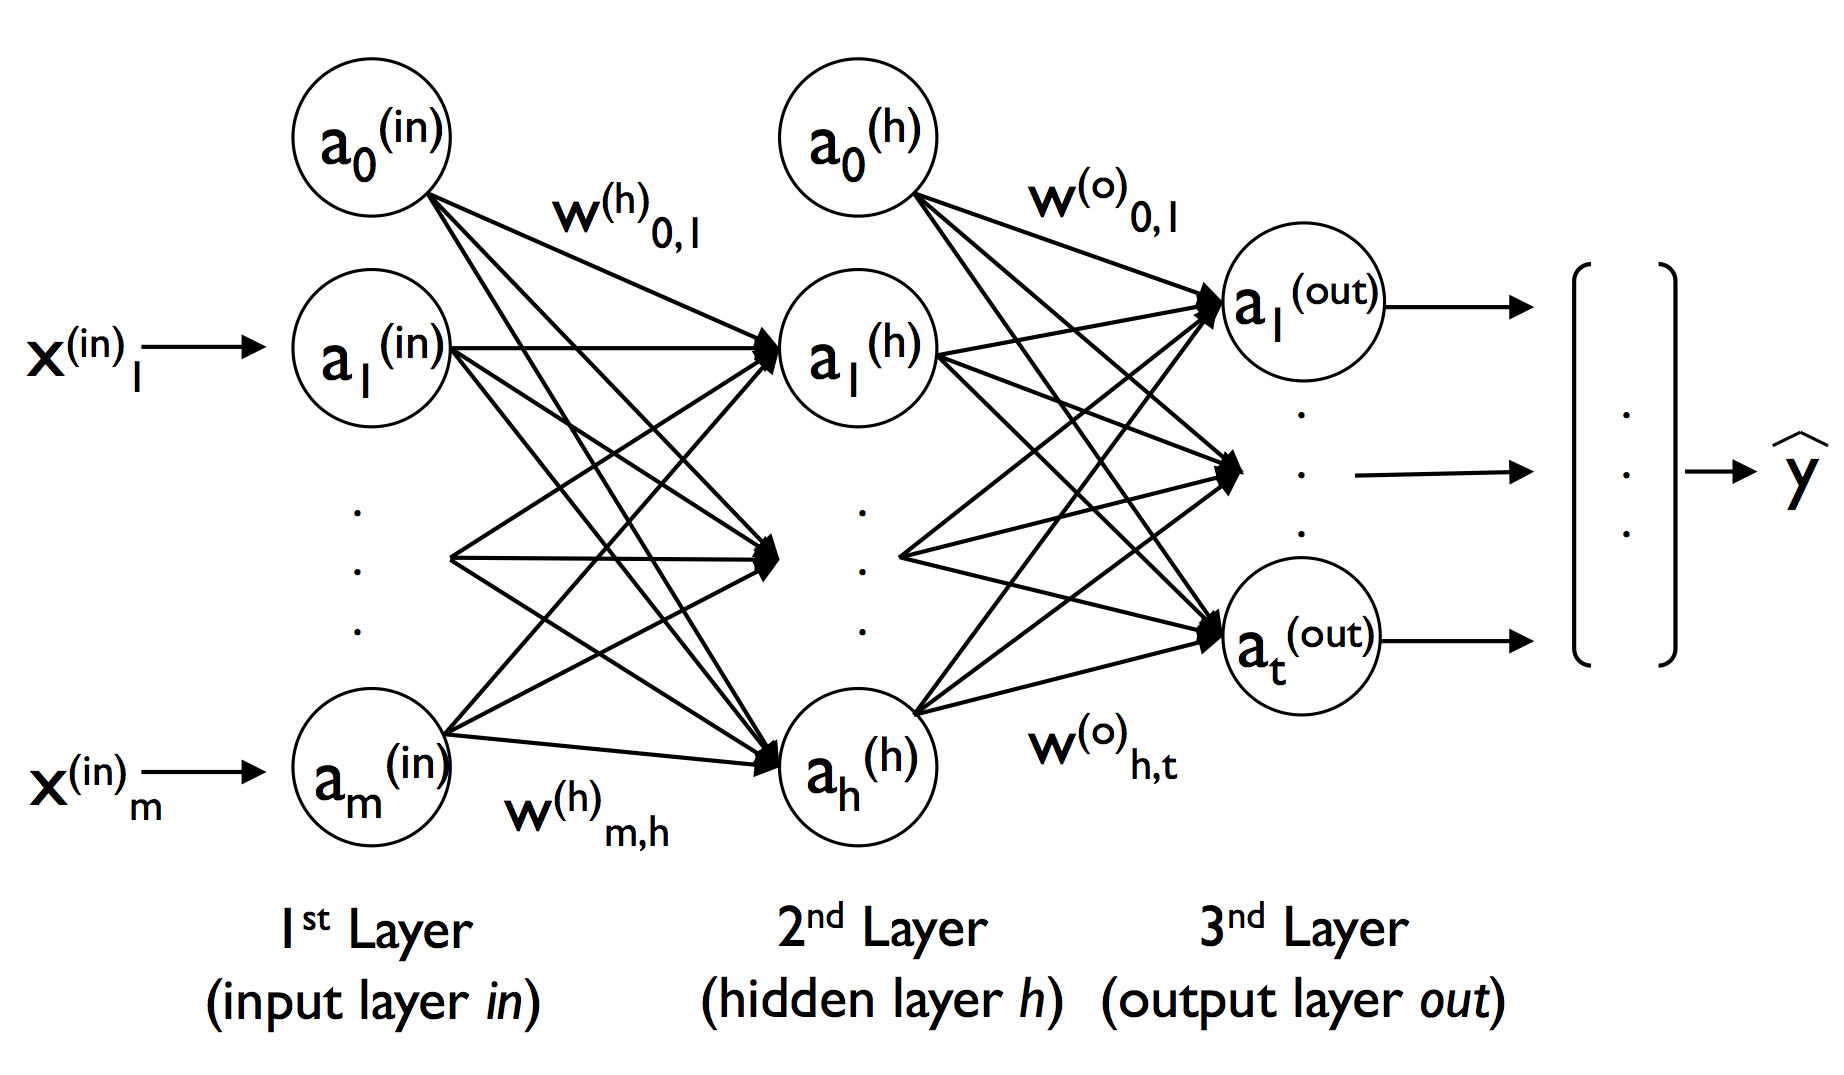

In [2]:
Image(filename='images/12_02.png', width=600) 

The MLP depicted in the preceding figure has one input layer, one hidden layer, and one output layer. The units in the hidden layer are fully connected to the input layer, and the output layer is fully connected to the hidden layer. If such a network has more than one hidden layer, we also call it a **deep artificial neural network**.

As shown in the preceding figure, we denote the **$i$th activation** unit in the $l$th layer as $a^{(i)}$. To make the math and code implementations a bit more intuitive, we will not use numerical indices to refer to layers, but we will use the $in$ superscript for the input layer, the $h$ superscript for the hidden layer, and the o superscript for the output layer. For instance, $a^{(n)}_i $refers to the $i$th value in the input layer, $a^{(h)}_i $ refers to
the $i$th unit in the hidden layer, and $a^{(out)}_i $ refers to the $i$th unit in the output layer.

Here, the activation units $a^{(in)}_0$ and $a^{(h)}_0$ are the $bias$ $units$, which we set equal to $1$. The activation of the units in the input layer is just its input plus the bias unit:

$$ a^{(in)} 
= \begin{pmatrix} a^{(in)}_0 \\ a^{(in)}_1  \\  \vdots \\ a^{(in)}_m \end{pmatrix} 
=  \begin{pmatrix} 1 \\ x^{(in)}_1  \\   \vdots \\ x^{(in)}_m  \end{pmatrix} $$ 

Each unit in layer $l$ is connected to all units in layer $l +1$ via a weight coefficient. For example, the connection between the $k$th unit in layer $l$ to the $j$th unit in layer $l +1$ will be written as $w^{(l+1)}_{k,j}$. Referring back to the previous figure, we denote the weight matrix that connects the input to the hidden layer as  $\mathbf{W}^{(h)}$, and we write the matrix
that connects the hidden layer to the output layer as $\mathbf{W}^{(out)}$.

While one unit in the output layer would suffice for a binary classification task, we saw a more general form of a neural network in the preceding figure, which allows us to perform multiclass classification via a generalization of the **One-versus-All
(OvA) technique**. To better understand how this works, remember the one-hot representation of categorical variables that we introduced in Chapter 4, Building Good Training Sets – Data Preprocessing. For example, we can encode the three class labels
in the familiar Iris dataset (0=Setosa, 1=Versicolor, 2=Virginica) as follows:

$$ 0 = \begin{pmatrix} 1 \\ 0 \\ 0\end{pmatrix}, \,
1 = \begin{pmatrix} 0 \\ 1 \\ 0\end{pmatrix}, \,
2 = \begin{pmatrix} 0 \\ 0 \\ 1\end{pmatrix}
$$                

This **one-hot vector representatio**n allows us to tackle classification tasks with an
arbitrary number of unique class labels present in the training set.
If you are new to neural network representations, the indexing notation (subscripts
and superscripts) may look a little bit confusing at first. What may seem overly complicated at first will make much more sense in later sections when we vectorize the neural network representation. As introduced earlier, we summarize the weights that connect the input and hidden layers by a matrix $\mathbf{W}^{(h)}\in \mathbb{R}^{m \times d} $, where $d$ is the number of hidden units and $m$ is the number of input units including the bias unit.
Since it is important to internalize this notation to follow the concepts later in this chapter, let's summarize what we have just learned in a descriptive illustration of a simplified **3-4-3 multilayer perceptron (MLP)**:

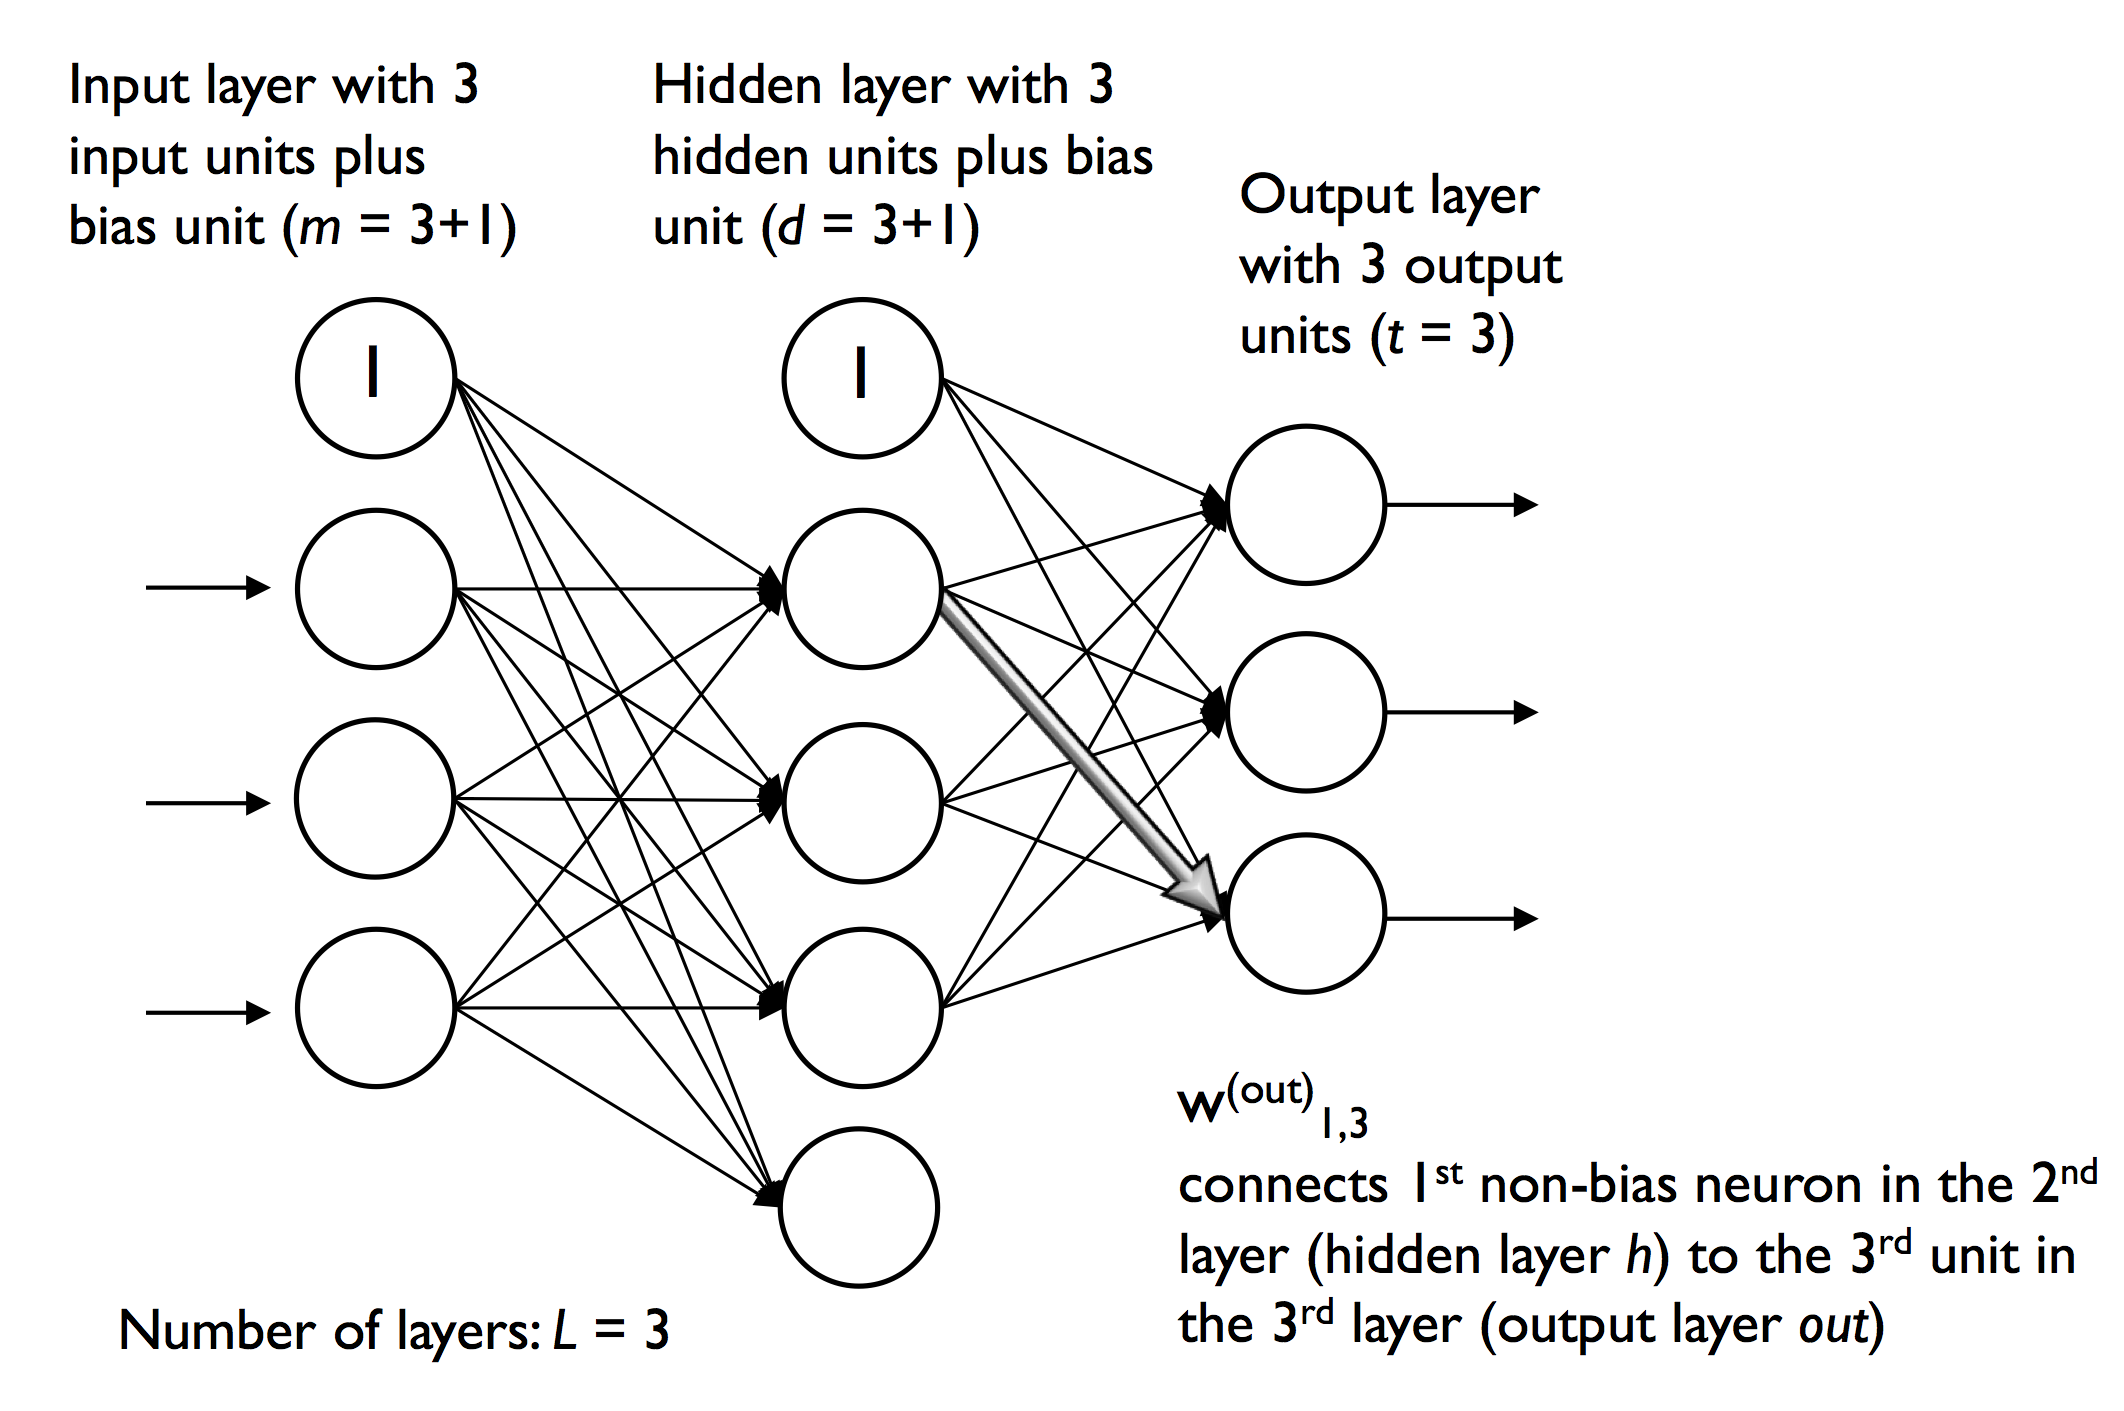

In [3]:
Image(filename='images/12_03.png', width=500) 

<br>
<br>

## Some details: Activating a neural network via forward propagation

In this section, we will describe the process of **forward propagation** to calculate the
output of an MLP model. To understand how it fits into the context of learning an
MLP model, let's summarize the MLP learning procedure in three simple steps:
1. Starting at the input layer, we forward propagate the patterns of the training
data through the network to generate an output.
2. Based on the network's output, we calculate the error that we want to
minimize using a cost function that we will describe later.
3. We backpropagate the error, find its derivative with respect to each weight in
the network, and update the model.
Finally, after we repeat these three steps for multiple epochs and learn the weights of
the MLP, we use forward propagation to calculate the network output and apply a threshold function to obtain the predicted class labels in the one-hot representation,
which we described in the previous section.
Now, let's walk through the individual steps of forward propagation to generate an output from the patterns in the training data. Since each unit in the hidden layer is
connected to all units in the input layers, we first calculate the activation unit of the
hidden layer  $a^{(h)}_i$ as follows:

$$ z^{(h)}_i = a^{(h)}_0 w_{0,1}^{(h)} +  a^{(in)}_1 w_{1,1}^{(h)} + \cdots + a^{(in)}_m w_{m,1}^{(h)}  $$
$$ a_1^{(h)} = \phi(z_1^{(h)})$$

Here, $z_1^{(h)}$ is the net input and $\phi(\dot)$ is the activation function, which has to be
differentiable to learn the weights that connect the neurons using a gradient-based
approach. To be able to solve complex problems such as image classification, we
need non-linear activation functions in our MLP model, for example, the sigmoid
(logistic) activation function 

$$ \phi(z) = \frac{1}{1+e^{-z}} $$

The sigmoid function is an S-shaped curve that maps the net
input $z$ onto a logistic distribution in the range $0$ to $1$, which cuts the $y$-axis at $z = 0,$ as shown in the following graph:

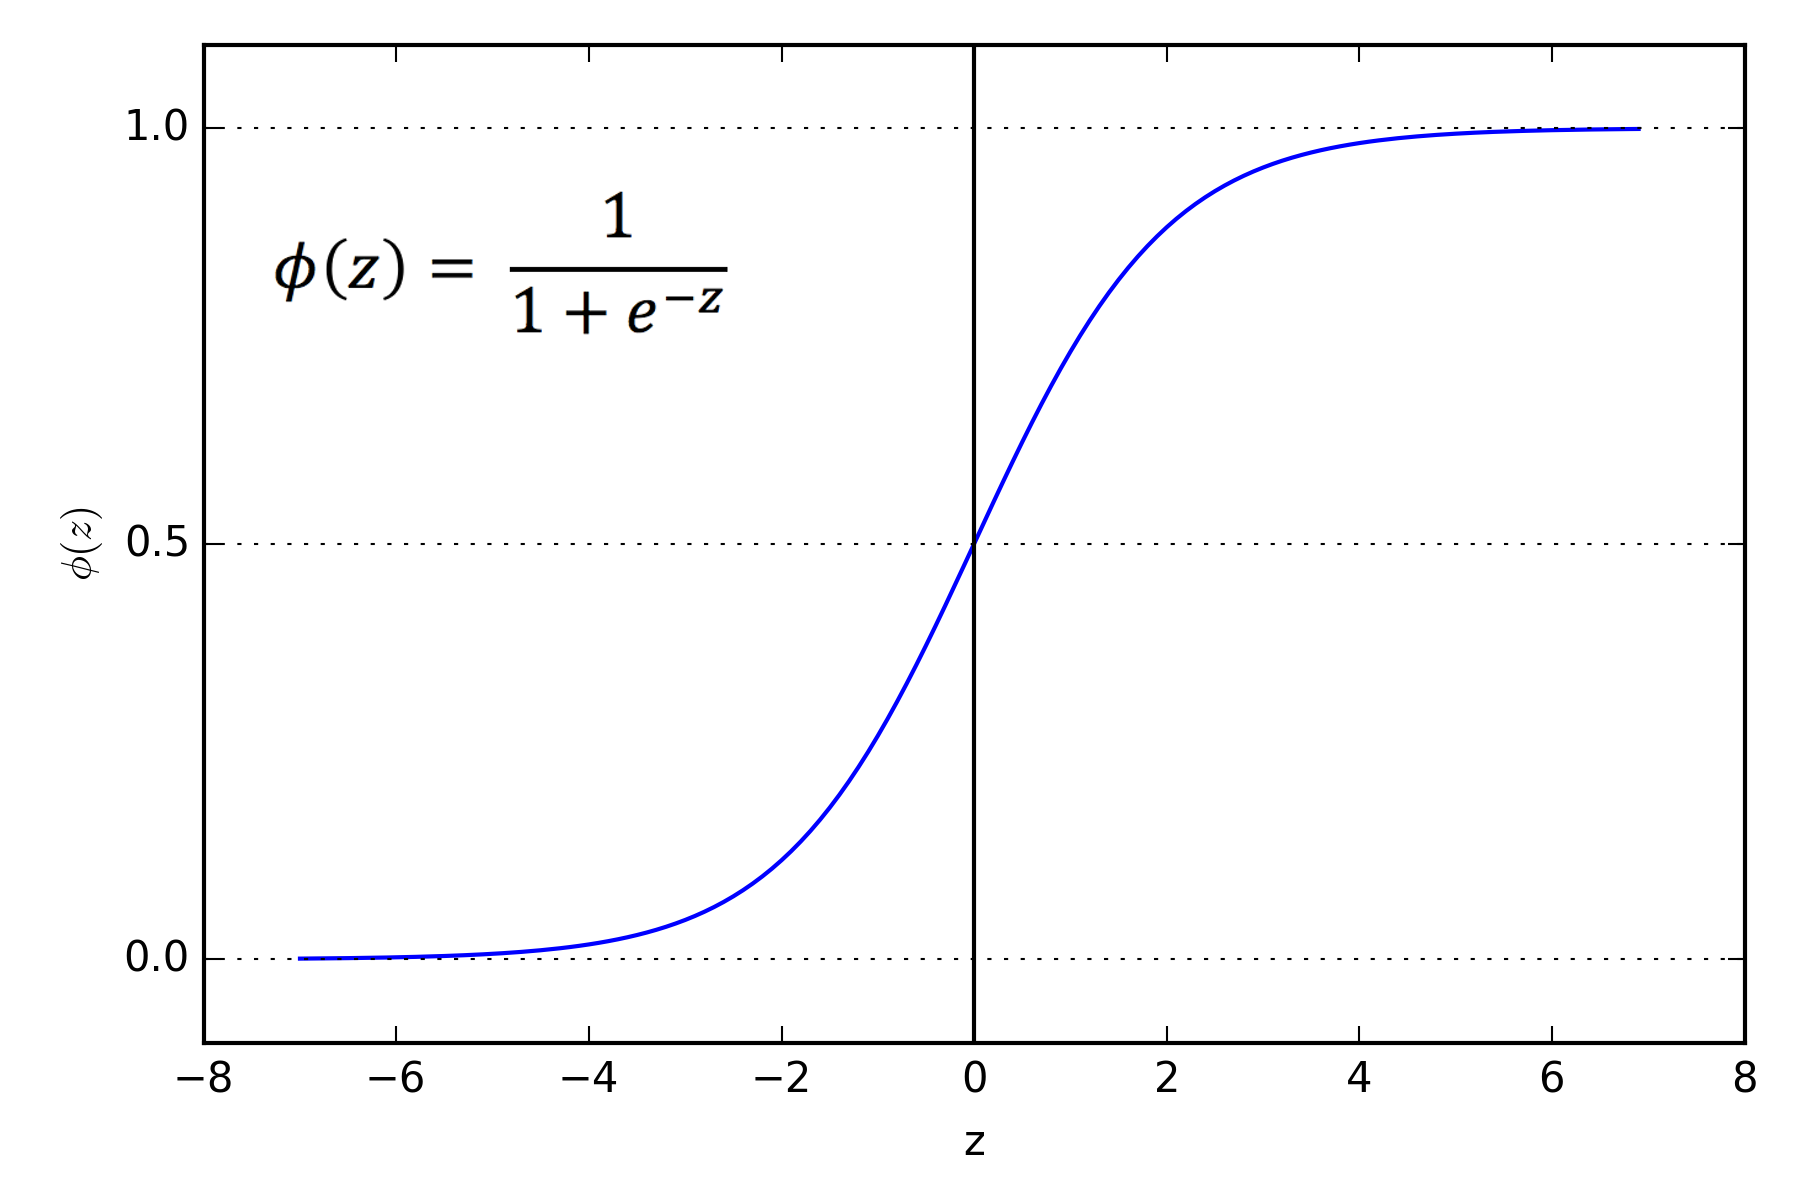

In [4]:
Image(filename='images/12_04.png', width=500) 

The term **feedforward refers** to the fact that each layer serves as the input to the next layer without loops. The term multilayer perceptron may sound a little bit confusing since the artificial neurons in this network architecture are typically sigmoid units, not perceptrons. Intuitively, we can think of the neurons in the MLP as logistic regression units that return values in the continuous range
between $0$ and $1$.
For purposes of code efficiency and readability, we will now write the activation in a more compact form using the concepts of basic linear algebra, which will allow us to vectorize our code implementation via NumPy rather than writing multiple nested and computationally expensive Python for loops:

$$ z^{(h)} = \mathbf{a}^{(in)} \mathbf{W}^{(h)} $$

$$ \mathbf{a}^{(h)} = \phi((z)^{(h)}) $$

Here, $\mathbf{a}^{(in)}$ is our $1 \times m$ dimensional feature vector of a sample $\mathbf{x}^{(in)}$ plus a bias unit.
\mathbf{W}^{(h)} is an $m \times d$  dimensional weight matrix where $d$ is the number of units in the hidden layer. After matrix-vector multiplication, we obtain the $1 \times d$ dimensional net
input vector $(z)^{(h)}$ to calculate the activation $\mathbf{a}^{(h)}$ (where $\mathbf{a}^{(h)}$ is in $\mathbb{R}^{1 \times d}$). 

#### Further generalization of the  notaion via matrices

Furthermore, we can generalize this computation to all n samples in the training set:

$$ \mathbf{Z}^{(h)} = \mathbf{A}^{(in)} \mathbf{W}^{(h)}  $$

Here, $\mathbf{A}^{(in)}$ is now an $n \times m$ matrix, and the matrix multiplication will result in an $n \times d$ dimensional net input matrix $\mathbf{Z}^{(h)}$. 
Finally, we apply the activation function $\phi(\dot)$ to each value in the net input matrix to get the $n \times d$ activation matrix $\mathbf{A}^{(h)}$ for the next layer (here, the output layer):

$$ \mathbf{A}^{(h)} =  \phi \left( \mathbf{Z}^{(h)}\right) $$

Similarly, we can write the activation of the output layer in vectorized form for
multiple samples:

$$ \mathbf{Z}^{(out)} = \mathbf{A}^{(h)} \mathbf{W}^{(out)}  $$

Here, we multiply the $d \times t$ matrix $\mathbf{W}^{(out)}$ ($t$ is the number of output units) by the $n \times d$
dimensional matrix $\mathbf{A}^{(h)} $ to obtain the $n \times t$ dimensional matrix $\mathbf{Z}^{(out)}$ (the columns in
this matrix represent the outputs for each sample).


Lastly, we apply the sigmoid activation function to obtain the continuous valued output of our network:

$$ \mathbf{A}^{(out)} =  \phi \left( \mathbf{Z}^{(out)}\right) \in $\mathbb{R}^{n \times t}$ $$

___________

# Classifying handwritten digits

In the previous section, we covered a lot of the theory around neural networks,
which can be a little bit overwhelming if you are new to this topic. Before we
continue with the discussion of the algorithm for learning the weights of the MLP
model, backpropagation, let's take a short break from the theory and see a neural
network in action.

In this section, we will implement and train our first multilayer neural network to
classify handwritten digits from the popular **Mixed National Institute of Standards
and Technology (MNIST)** dataset that has been constructed by Yann LeCun and
others, and serves as a popular benchmark dataset for machine learning algorithms
(*Gradient-Based Learning Applied to Document Recognition, Y. LeCun, L. Bottou, Y.Bengio, and P. Haffner*, Proceedings of the IEEE, 86(11): 2278-2324, November 1998).

## Obtaining the MNIST dataset

The MNIST dataset is publicly available at http://yann.lecun.com/exdb/mnist/ and consists of the following four parts:

- Training set images: train-images-idx3-ubyte.gz (9.9 MB, 47 MB unzipped, 60,000 samples)
- Training set labels: train-labels-idx1-ubyte.gz (29 KB, 60 KB unzipped, 60,000 labels)
- Test set images: t10k-images-idx3-ubyte.gz (1.6 MB, 7.8 MB, 10,000 samples)
- Test set labels: t10k-labels-idx1-ubyte.gz (5 KB, 10 KB unzipped, 10,000 labels)

In this section, we will only be working with a subset of MNIST, thus, we only need to download the training set images and training set labels. After downloading the files, I recommend unzipping the files using the Unix/Linux gzip tool from the terminal for efficiency, e.g., using the command 

    gzip *ubyte.gz -d
 
(see the code below) in your local MNIST download directory, or, using your favorite unzipping tool if you are working with a machine running on Microsoft Windows. The images are stored in byte form, and using the following function, we will read them into NumPy arrays that we will use to train our MLP.


In [5]:
import os
import struct
import numpy as np
 
def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path, 
                               '%s-labels-idx1-ubyte' % kind)
    images_path = os.path.join(path, 
                               '%s-images-idx3-ubyte' % kind)
        
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', 
                                 lbpath.read(8))
        labels = np.fromfile(lbpath, 
                             dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", 
                                               imgpath.read(16))
        images = np.fromfile(imgpath, 
                             dtype=np.uint8).reshape(len(labels), 784)
        images = ((images / 255.) - .5) * 2
 
    return images, labels

The *load_mnist* function returns two arrays, the first being an *n x m* dimensional NumPy array (images), where n is the number of samples and *m* is the number offeatures (here, pixels). The training dataset consists of 60,000 training digits and
the test set contains 10,000 samples, respectively. The images in the MNIST dataset
consist of *28 x 28* pixels, and each pixel is represented by a gray scale intensity value.
Here, we unroll the *28 x 28* pixels into one-dimensional row vectors, which represent
the rows in our images array (784 per row or image). The second array (labels)
returned by the load_mnist function contains the corresponding target variable, the
class labels (integers 0-9) of the handwritten digits.


Note that we scaled the images on a pixel-by-pixel
basis, which is different from the feature scaling approach that we took in previous
chapters. Previously, we derived scaling parameters from the training set and used
these to scale each column in the training set and test set. However, when working
with image pixels, centering them at zero and rescaling them to a [-1, 1] range is alsocommon and usually works well in practice.

By executing the following code, we will now load the 60,000 training instances
as well as the 10,000 test samples from the local directory where we unzipped the
MNIST dataset (in the following code snippet, it is assumed that the downloaded
MNIST files are unzipped to the same directory in which this code was executed):

In [6]:
# unzips mnist

import sys
import gzip
import shutil

if (sys.version_info > (3, 0)):
    writemode = 'wb'
else:
    writemode = 'w'

zipped_mnist = [f for f in os.listdir('./') if f.endswith('ubyte.gz')]
for z in zipped_mnist:
    with gzip.GzipFile(z, mode='rb') as decompressed, open(z[:-3], writemode) as outfile:
        outfile.write(decompressed.read()) 

In [7]:
X_train, y_train = load_mnist('', kind='train')
print('Rows: %d, columns: %d' % (X_train.shape[0], X_train.shape[1]))

X_test, y_test = load_mnist('', kind='t10k')
#print('Rows: %d, columns: %d' % (X_train.shape[0], X_train.shape[1]))

Rows: 60000, columns: 784


To get an idea of how those images in MNIST look, let's visualize examples of the
digits 0-9 after reshaping the 784-pixel vectors from our feature matrix into the
original 28 × 28 image that we can plot via Matplotlib's imshow function:

Visualize the first digit of each class:

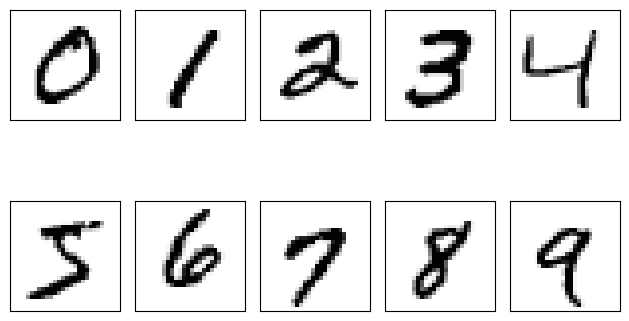

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(10):
    img = X_train[y_train == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('images/12_5.png', dpi=300)
plt.show()

In addition, let's also plot multiple examples of the same digit to see how different
the handwriting really is:

Visualize 25 different versions of "7":

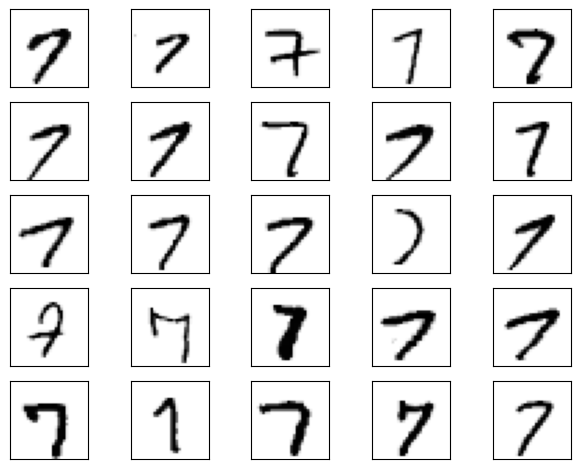

In [9]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(25):
    img = X_train[y_train == 7][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('images/12_6.png', dpi=300)
plt.show()

After we've gone through all the previous steps, it is a good idea to save the scaled
images in a format that we can load more quickly into a new Python session to avoid
the overhead of reading in and processing the data again. When we are working with
NumPy arrays, an efficient yet most convenient method to save multidimensional
arrays to disk is **NumPy's savez function** (the official documentation can be found
here: 
https://docs.scipy.org/doc/numpy/reference/generated/numpy.savez.html).

In short, the savez function is analogous to Python's pickle module that we used in
Chapter 9, Embedding a Machine Learning Model into a Web Application, but optimized
for storing NumPy arrays. The savez function produces zipped archives of our data,
producing .npz files that contain files in the .npy format; if you want to learn more
about this format, you can find a nice explanation, including a discussion about
advantages and disadvantages, in the NumPy documentation: https://docs.
scipy.org/doc/numpy/neps/npy-format.html. Further, instead of using savez,
we will use *savez_compressed*, which uses the same syntax as savez, but further
compresses the output file down to substantially smaller file sizes (approximately 22 MB versus approximately 400 MB in this case). 

The following code snippet will save
both the training and test datasets to the archive file 'mnist_scaled.npz':

In [10]:
import numpy as np

np.savez_compressed('mnist_scaled.npz', 
                    X_train=X_train,
                    y_train=y_train,
                    X_test=X_test,
                    y_test=y_test)

After we created the .npz files, we can load the preprocessed MNIST image arrays
using NumPy's load function as follows:

In [11]:
mnist = np.load('mnist_scaled.npz')

The mnist variable now references to an object that can access the four data arrays
as we provided them keyword arguments to the savez_compressed function, which
are listed under the files attribute list of the mnist object:

In [12]:
mnist.files

['X_train', 'y_train', 'X_test', 'y_test']

Note that while the preceding np.savez_compressed and np.load examples are not
essential for executing the code in this chapter, it serves as a demonstration of how to
save and load NumPy arrays conveniently and efficiently.

## Implementing a multi-layer perceptron

In this subsection, we will now implement the code of an MLP with one input, one hidden, and one output layers to classify the images in the MNIST dataset. The code is kept as simple as possible. However, it may seem a little bit complicated at first.

In [27]:
from neuralnet import NeuralNetMLP

The code will contain parts that we have not talked about yet.
**Do not worry if not all of the code makes immediate sense to you**; we will follow up
on certain parts later in this chapter. However, going over the code at this stage can
make it easier to follow the theory later.

The following is the implementation of a **multilayer perceptron**:

In [14]:
import numpy as np
import sys


class NeuralNetMLP(object):
    """ Feedforward neural network / Multi-layer perceptron classifier.

    Parameters
    ------------
    n_hidden : int (default: 30)
        Number of hidden units.
    l2 : float (default: 0.)
        Lambda value for L2-regularization.
        No regularization if l2=0. (default)
    epochs : int (default: 100)
        Number of passes over the training set.
    eta : float (default: 0.001)
        Learning rate.
    shuffle : bool (default: True)
        Shuffles training data every epoch if True to prevent circles.
    minibatche_size : int (default: 1)
        Number of training samples per minibatch.
    seed : int (default: None)
        Random seed for initalizing weights and shuffling.

    Attributes
    -----------
    eval_ : dict
      Dictionary collecting the cost, training accuracy,
      and validation accuracy for each epoch during training.

    """
    def __init__(self, n_hidden=30,
                 l2=0., epochs=100, eta=0.001,
                 shuffle=True, minibatch_size=1, seed=None):

        self.random = np.random.RandomState(seed)
        self.n_hidden = n_hidden
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.shuffle = shuffle
        self.minibatch_size = minibatch_size

    def _onehot(self, y, n_classes):
        """Encode labels into one-hot representation

        Parameters
        ------------
        y : array, shape = [n_samples]
            Target values.

        Returns
        -----------
        onehot : array, shape = (n_samples, n_labels)

        """
        onehot = np.zeros((n_classes, y.shape[0]))
        for idx, val in enumerate(y.astype(int)):
            onehot[val, idx] = 1.
        return onehot.T

    def _sigmoid(self, z):
        """Compute logistic function (sigmoid)"""
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))

    def _forward(self, X):
        """Compute forward propagation step"""

        # step 1: net input of hidden layer
        # [n_samples, n_features] dot [n_features, n_hidden]
        # -> [n_samples, n_hidden]
        z_h = np.dot(X, self.w_h) + self.b_h

        # step 2: activation of hidden layer
        a_h = self._sigmoid(z_h)

        # step 3: net input of output layer
        # [n_samples, n_hidden] dot [n_hidden, n_classlabels]
        # -> [n_samples, n_classlabels]

        z_out = np.dot(a_h, self.w_out) + self.b_out

        # step 4: activation output layer
        a_out = self._sigmoid(z_out)

        return z_h, a_h, z_out, a_out

    def _compute_cost(self, y_enc, output):
        """Compute cost function.

        Parameters
        ----------
        y_enc : array, shape = (n_samples, n_labels)
            one-hot encoded class labels.
        output : array, shape = [n_samples, n_output_units]
            Activation of the output layer (forward propagation)

        Returns
        ---------
        cost : float
            Regularized cost

        """
        L2_term = (self.l2 *
                   (np.sum(self.w_h ** 2.) +
                    np.sum(self.w_out ** 2.)))

        term1 = -y_enc * (np.log(output))
        term2 = (1. - y_enc) * np.log(1. - output)
        cost = np.sum(term1 - term2) + L2_term
        return cost

    def predict(self, X):
        """Predict class labels

        Parameters
        -----------
        X : array, shape = [n_samples, n_features]
            Input layer with original features.

        Returns:
        ----------
        y_pred : array, shape = [n_samples]
            Predicted class labels.

        """
        z_h, a_h, z_out, a_out = self._forward(X)
        y_pred = np.argmax(z_out, axis=1)
        return y_pred

    def fit(self, X_train, y_train, X_valid, y_valid):
        """ Learn weights from training data.

        Parameters
        -----------
        X_train : array, shape = [n_samples, n_features]
            Input layer with original features.
        y_train : array, shape = [n_samples]
            Target class labels.
        X_valid : array, shape = [n_samples, n_features]
            Sample features for validation during training
        y_valid : array, shape = [n_samples]
            Sample labels for validation during training

        Returns:
        ----------
        self

        """
        n_output = np.unique(y_train).shape[0]  # number of class labels
        n_features = X_train.shape[1]

        ########################
        # Weight initialization
        ########################

        # weights for input -> hidden
        self.b_h = np.zeros(self.n_hidden)
        self.w_h = self.random.normal(loc=0.0, scale=0.1,
                                      size=(n_features, self.n_hidden))

        # weights for hidden -> output
        self.b_out = np.zeros(n_output)
        self.w_out = self.random.normal(loc=0.0, scale=0.1,
                                        size=(self.n_hidden, n_output))

        epoch_strlen = len(str(self.epochs))  # for progress formatting
        self.eval_ = {'cost': [], 'train_acc': [], 'valid_acc': []}

        y_train_enc = self._onehot(y_train, n_output)

        # iterate over training epochs
        for i in range(self.epochs):

            # iterate over minibatches
            indices = np.arange(X_train.shape[0])

            if self.shuffle:
                self.random.shuffle(indices)

            for start_idx in range(0, indices.shape[0] - self.minibatch_size +
                                   1, self.minibatch_size):
                batch_idx = indices[start_idx:start_idx + self.minibatch_size]

                # forward propagation
                z_h, a_h, z_out, a_out = self._forward(X_train[batch_idx])

                ##################
                # Backpropagation
                ##################

                # [n_samples, n_classlabels]
                sigma_out = a_out - y_train_enc[batch_idx]

                # [n_samples, n_hidden]
                sigmoid_derivative_h = a_h * (1. - a_h)

                # [n_samples, n_classlabels] dot [n_classlabels, n_hidden]
                # -> [n_samples, n_hidden]
                sigma_h = (np.dot(sigma_out, self.w_out.T) *
                           sigmoid_derivative_h)

                # [n_features, n_samples] dot [n_samples, n_hidden]
                # -> [n_features, n_hidden]
                grad_w_h = np.dot(X_train[batch_idx].T, sigma_h)
                grad_b_h = np.sum(sigma_h, axis=0)

                # [n_hidden, n_samples] dot [n_samples, n_classlabels]
                # -> [n_hidden, n_classlabels]
                grad_w_out = np.dot(a_h.T, sigma_out)
                grad_b_out = np.sum(sigma_out, axis=0)

                # Regularization and weight updates
                delta_w_h = (grad_w_h + self.l2*self.w_h)
                delta_b_h = grad_b_h # bias is not regularized
                self.w_h -= self.eta * delta_w_h
                self.b_h -= self.eta * delta_b_h

                delta_w_out = (grad_w_out + self.l2*self.w_out)
                delta_b_out = grad_b_out  # bias is not regularized
                self.w_out -= self.eta * delta_w_out
                self.b_out -= self.eta * delta_b_out

            #############
            # Evaluation
            #############

            # Evaluation after each epoch during training
            z_h, a_h, z_out, a_out = self._forward(X_train)
            
            cost = self._compute_cost(y_enc=y_train_enc,
                                      output=a_out)

            y_train_pred = self.predict(X_train)
            y_valid_pred = self.predict(X_valid)

            train_acc = ((np.sum(y_train == y_train_pred)).astype(float) /
                         X_train.shape[0])
            valid_acc = ((np.sum(y_valid == y_valid_pred)).astype(float) /
                         X_valid.shape[0])

            sys.stderr.write('\r%0*d/%d | Cost: %.2f '
                             '| Train/Valid Acc.: %.2f%%/%.2f%% ' %
                             (epoch_strlen, i+1, self.epochs, cost,
                              train_acc*100, valid_acc*100))
            sys.stderr.flush()

            self.eval_['cost'].append(cost)
            self.eval_['train_acc'].append(train_acc)
            self.eval_['valid_acc'].append(valid_acc)

        return self

In [15]:
n_epochs = 200 ## Sollte der Code (nn-fit) unten zu lange laufen, hier runtersetzen

## @Readers: PLEASE IGNORE IF-STATEMENT BELOW
##
## This cell is meant to run fewer epochs when
## the notebook is run on the Travis Continuous Integration
## platform to test the code on a smaller dataset
## to prevent timeout errors; it just serves a debugging tool

if 'TRAVIS' in os.environ:
    n_epochs = 20
    
    
    

Once you're done with executing this code, let's now initialize a new 784-100-10
MLP—a neural network with 784 input units (n_features), 100 hidden units
(n_hidden), and 10 output units (n_output):

In [16]:
nn = NeuralNetMLP(n_hidden=100, 
                  l2=0.01, 
                  epochs=n_epochs, 
                  eta=0.0005,
                  minibatch_size=100, 
                  shuffle=True,
                  seed=1)



If you read through the NeuralNetMLP code, you've probably already guessed what
these parameters are for. Here, you find a short summary of these:
- l2: This is the   **parameter for L2 regularization** to decrease the degree of overfitting.
- **epochs**: This is the number of passes over the training set.
- **eta**: This is the learning rate   .
- **shuffle**: This is for shuffling the training set prior to every epoch to prevent that the algorithm gets stuck in circles.
- **seed**: This is a random seed for shuffling and weight initialization.
- **minibatch_size**: This is the number of training samples in each mini-batch when splitting of the training data in each epoch for **stochastic gradient descent**. The gradient is computed for each mini-batch separately instead of the entire training data for faster learning.

Next, we train the MLP using 55,000 samples from the already shuffled MNIST
training dataset and use the remaining 5,000 samples for validation during training.
Note that training the neural network may take up to 5 minutes on standard desktop
computer hardware.
As you may have noticed from the preceding code implementation, we implemented the fit method so that it takes four input arguments: training images, training
labels, validation images, and validation labels. In neural network training, it is really
useful to already compare training and validation accuracy during training, which
helps us judge whether the network model performs well, given the architecture and
hyperparameters



In [17]:
nn.fit(X_train=X_train[:55000], 
       y_train=y_train[:55000],
       X_valid=X_train[55000:],
       y_valid=y_train[55000:])

200/200 | Cost: 5065.78 | Train/Valid Acc.: 99.28%/97.98%  

In our NeuralNetMLP implementation, we also defined an eval_ attribute that collects the cost, training, and validation accuracy for each epoch so that we can visualize the results using Matplotlib. The following code plots the cost over the 200 epochs, as shown in the following graph:

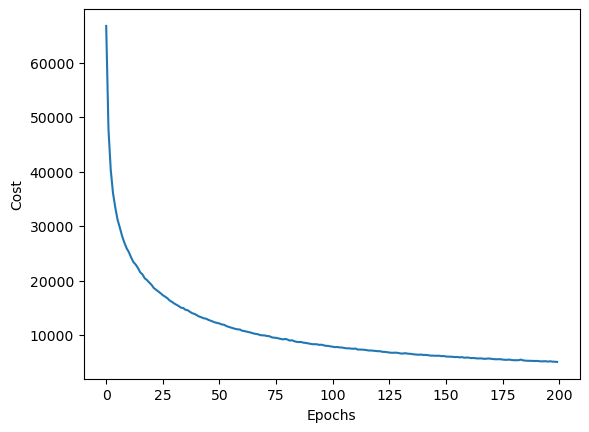

In [18]:
import matplotlib.pyplot as plt

plt.plot(range(nn.epochs), nn.eval_['cost'])
plt.ylabel('Cost')
plt.xlabel('Epochs')
#plt.savefig('images/12_07.png', dpi=300)
plt.show()

As we can see, the cost decreased substantially during the first 100 epochs and seems to slowly converge in the last 100 epochs. However, the small slope between epoch 175 and epoch 200 indicates that the cost would further decrease with a training over additional epochs.

Next, let's take a look at the training and validation accuracy. The following code examples plot those accuracy values over the 200 training epochs, as shown in the following figure:

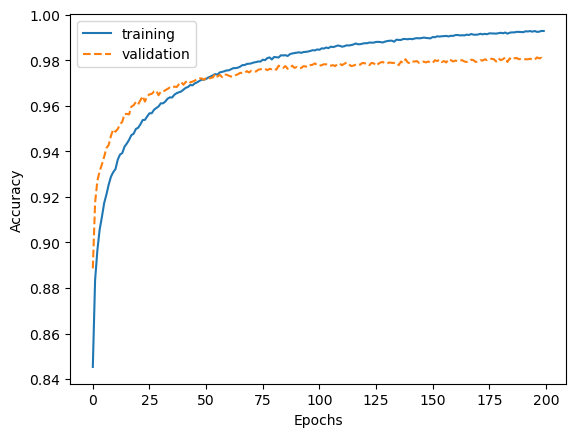

In [19]:
plt.plot(range(nn.epochs), nn.eval_['train_acc'], 
         label='training')
plt.plot(range(nn.epochs), nn.eval_['valid_acc'], 
         label='validation', linestyle='--')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
#plt.savefig('images/12_08.png', dpi=300)
plt.show()

The plot reveals that the gap between training and validation accuracy increases the more epochs we train the network. At approximately the 50th epoch, the training and validation accuracy values are equal, and then, the network starts overfitting the training data.

Note that this example was chosen deliberately to illustrate the effect of overfitting and demonstrate why it is useful to compare the validation and training accuracy values during training. One way to decrease the effect of overfitting is to increase the regularization strength—for example, by setting $l2=0.1$. 
Another useful technique to tackle overfitting in neural networks, dropout, will be covered in Chapter 15, Classifying Images with Deep Convolutional Neural Networks. Finally, let's evaluate the generalization performance of the model by calculating the
prediction accuracy on the test set:

In [20]:
y_test_pred = nn.predict(X_test)

acc = (np.sum(y_test == y_test_pred)
       .astype(float) / X_test.shape[0])

print('Test accuracy: %.2f%%' % (acc * 100))

Test accuracy: 97.54%


In [21]:
# just for testing data formats:
X_test.shape

(10000, 784)

In [22]:
28*28

784

Despite the slight overfitting on the training data, our relatively simple one-hidden
layer neural network achieved a relatively good performance on the test dataset,
similar to the validation set accuracy (97.98 percent).
To further fine-tune the model, we could change the number of hidden units,
values of the regularization parameters, and the learning rate or use various other
tricks that have been developed over the years but are beyond the scope of this
book. In *Raschka and Mirjalili (2017), Chapter 14, Going Deeper – The Mechanics of TensorFlow*, you will learn about
a different neural network architecture that is known for its good performance on
image datasets. Also, the chapter will introduce additional performance-enhancing
tricks such as adaptive learning rates, momentum learning, and dropout.
Lastly, let's take a look at some of the images that our MLP struggles with:

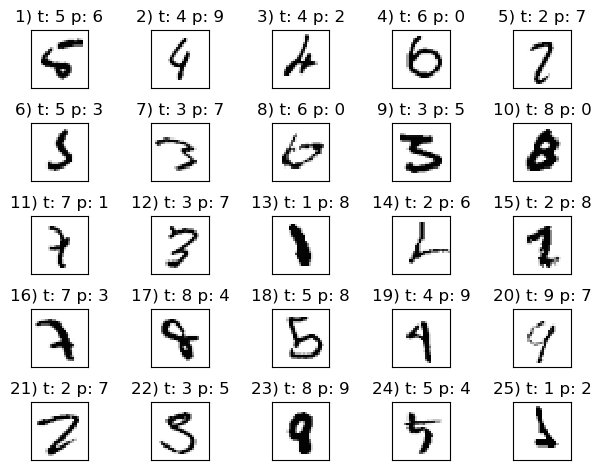

In [23]:
miscl_img = X_test[y_test != y_test_pred][:25]
correct_lab = y_test[y_test != y_test_pred][:25]
miscl_lab = y_test_pred[y_test != y_test_pred][:25]


fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(25):
    img = miscl_img[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title('%d) t: %d p: %d' % (i+1, correct_lab[i], miscl_lab[i]))

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
#plt.savefig('images/12_09.png', dpi=300)
plt.show()

We should now see a *5 x 5* subplot matrix where 
- the first number in the subtitles indicates the plot index
- the second number represents the true class label (t)
- the third number stands for the predicted class label (p)

As we can see in the preceding figure, some of those images are even challenging
for us humans to classify correctly. For example, the 6 in subplot 8 really looks like a
carelessly drawn 0, and the 8 in subplot 23 could be a 9 due to the narrow lower part
combined with the bold line.

## Training neural networks via backpropagation

An illustration how you backpropagation works:

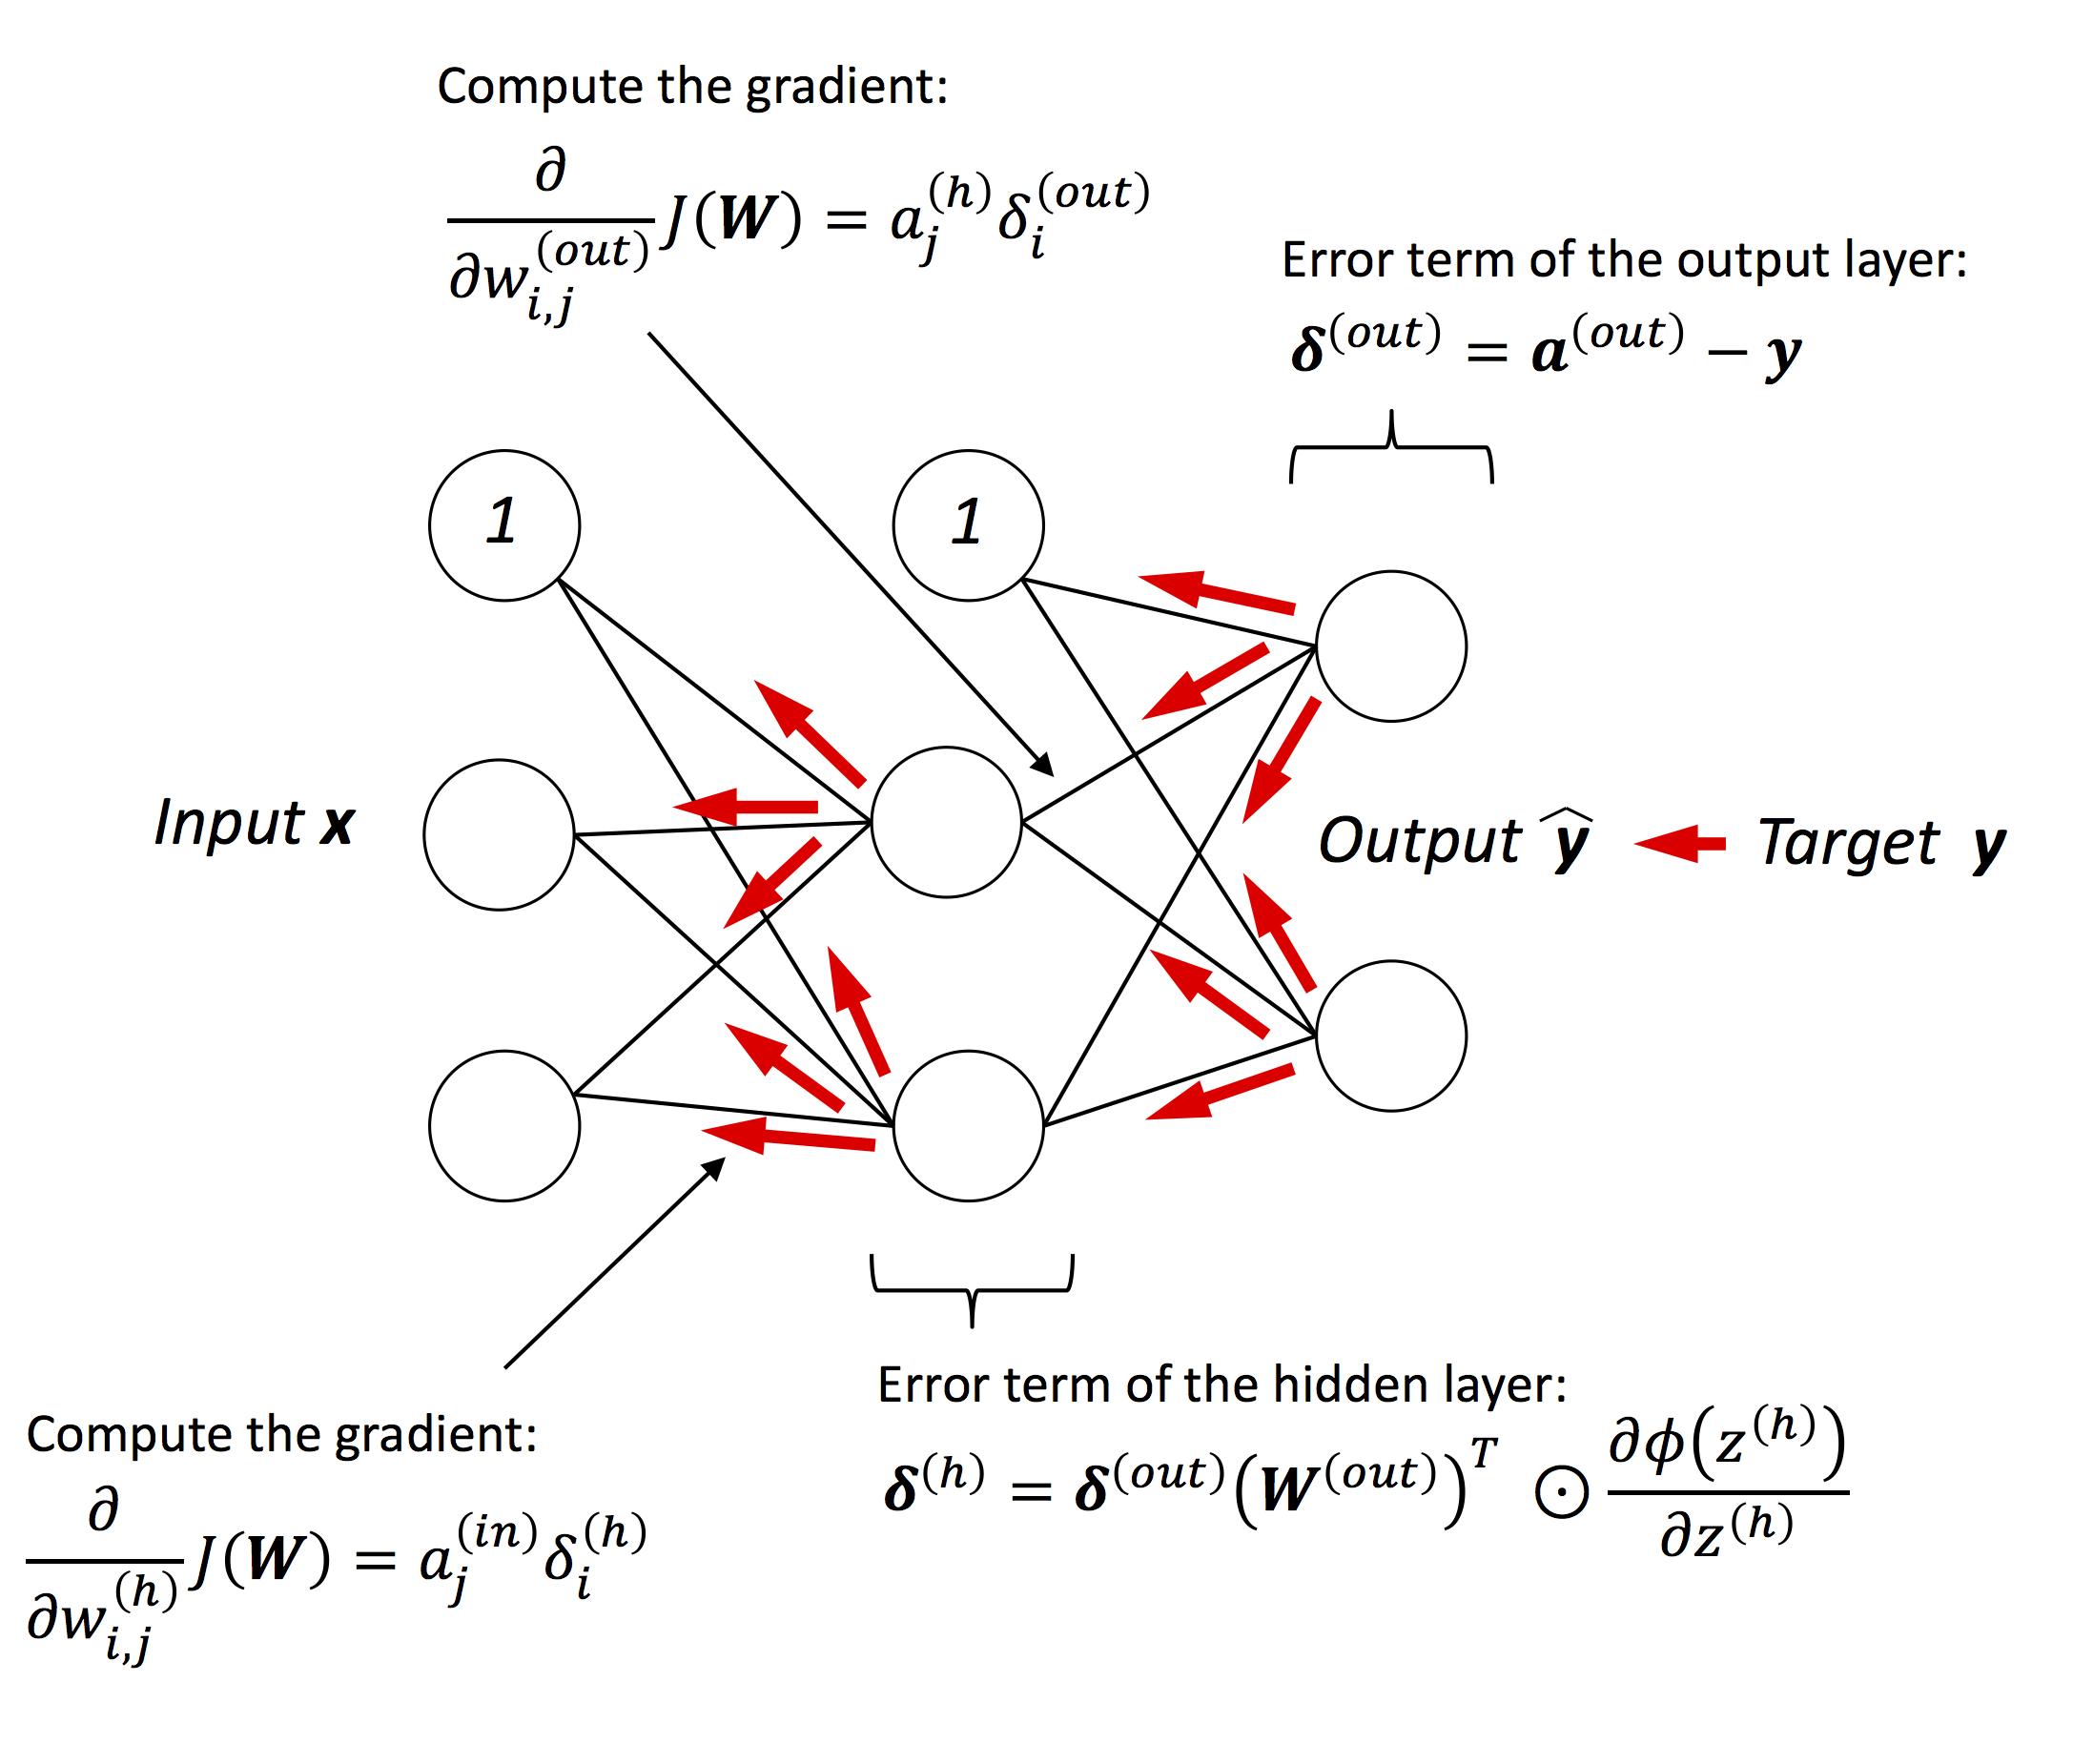

In [24]:
Image(filename='images/12_12.png', width=500) 

<br>
<br>

# Convergence in neural networks

Multilayer neural networks are much harder to train than simpler algorithms such
as Adaline, logistic regression, or support vector machines. In multilayer neural
networks, we typically have hundreds, thousands, or even billions of weights that
we need to optimize. Unfortunately, the output function has a rough surface and the
optimization algorithm can easily become trapped in local minima, as shown in the
following figure




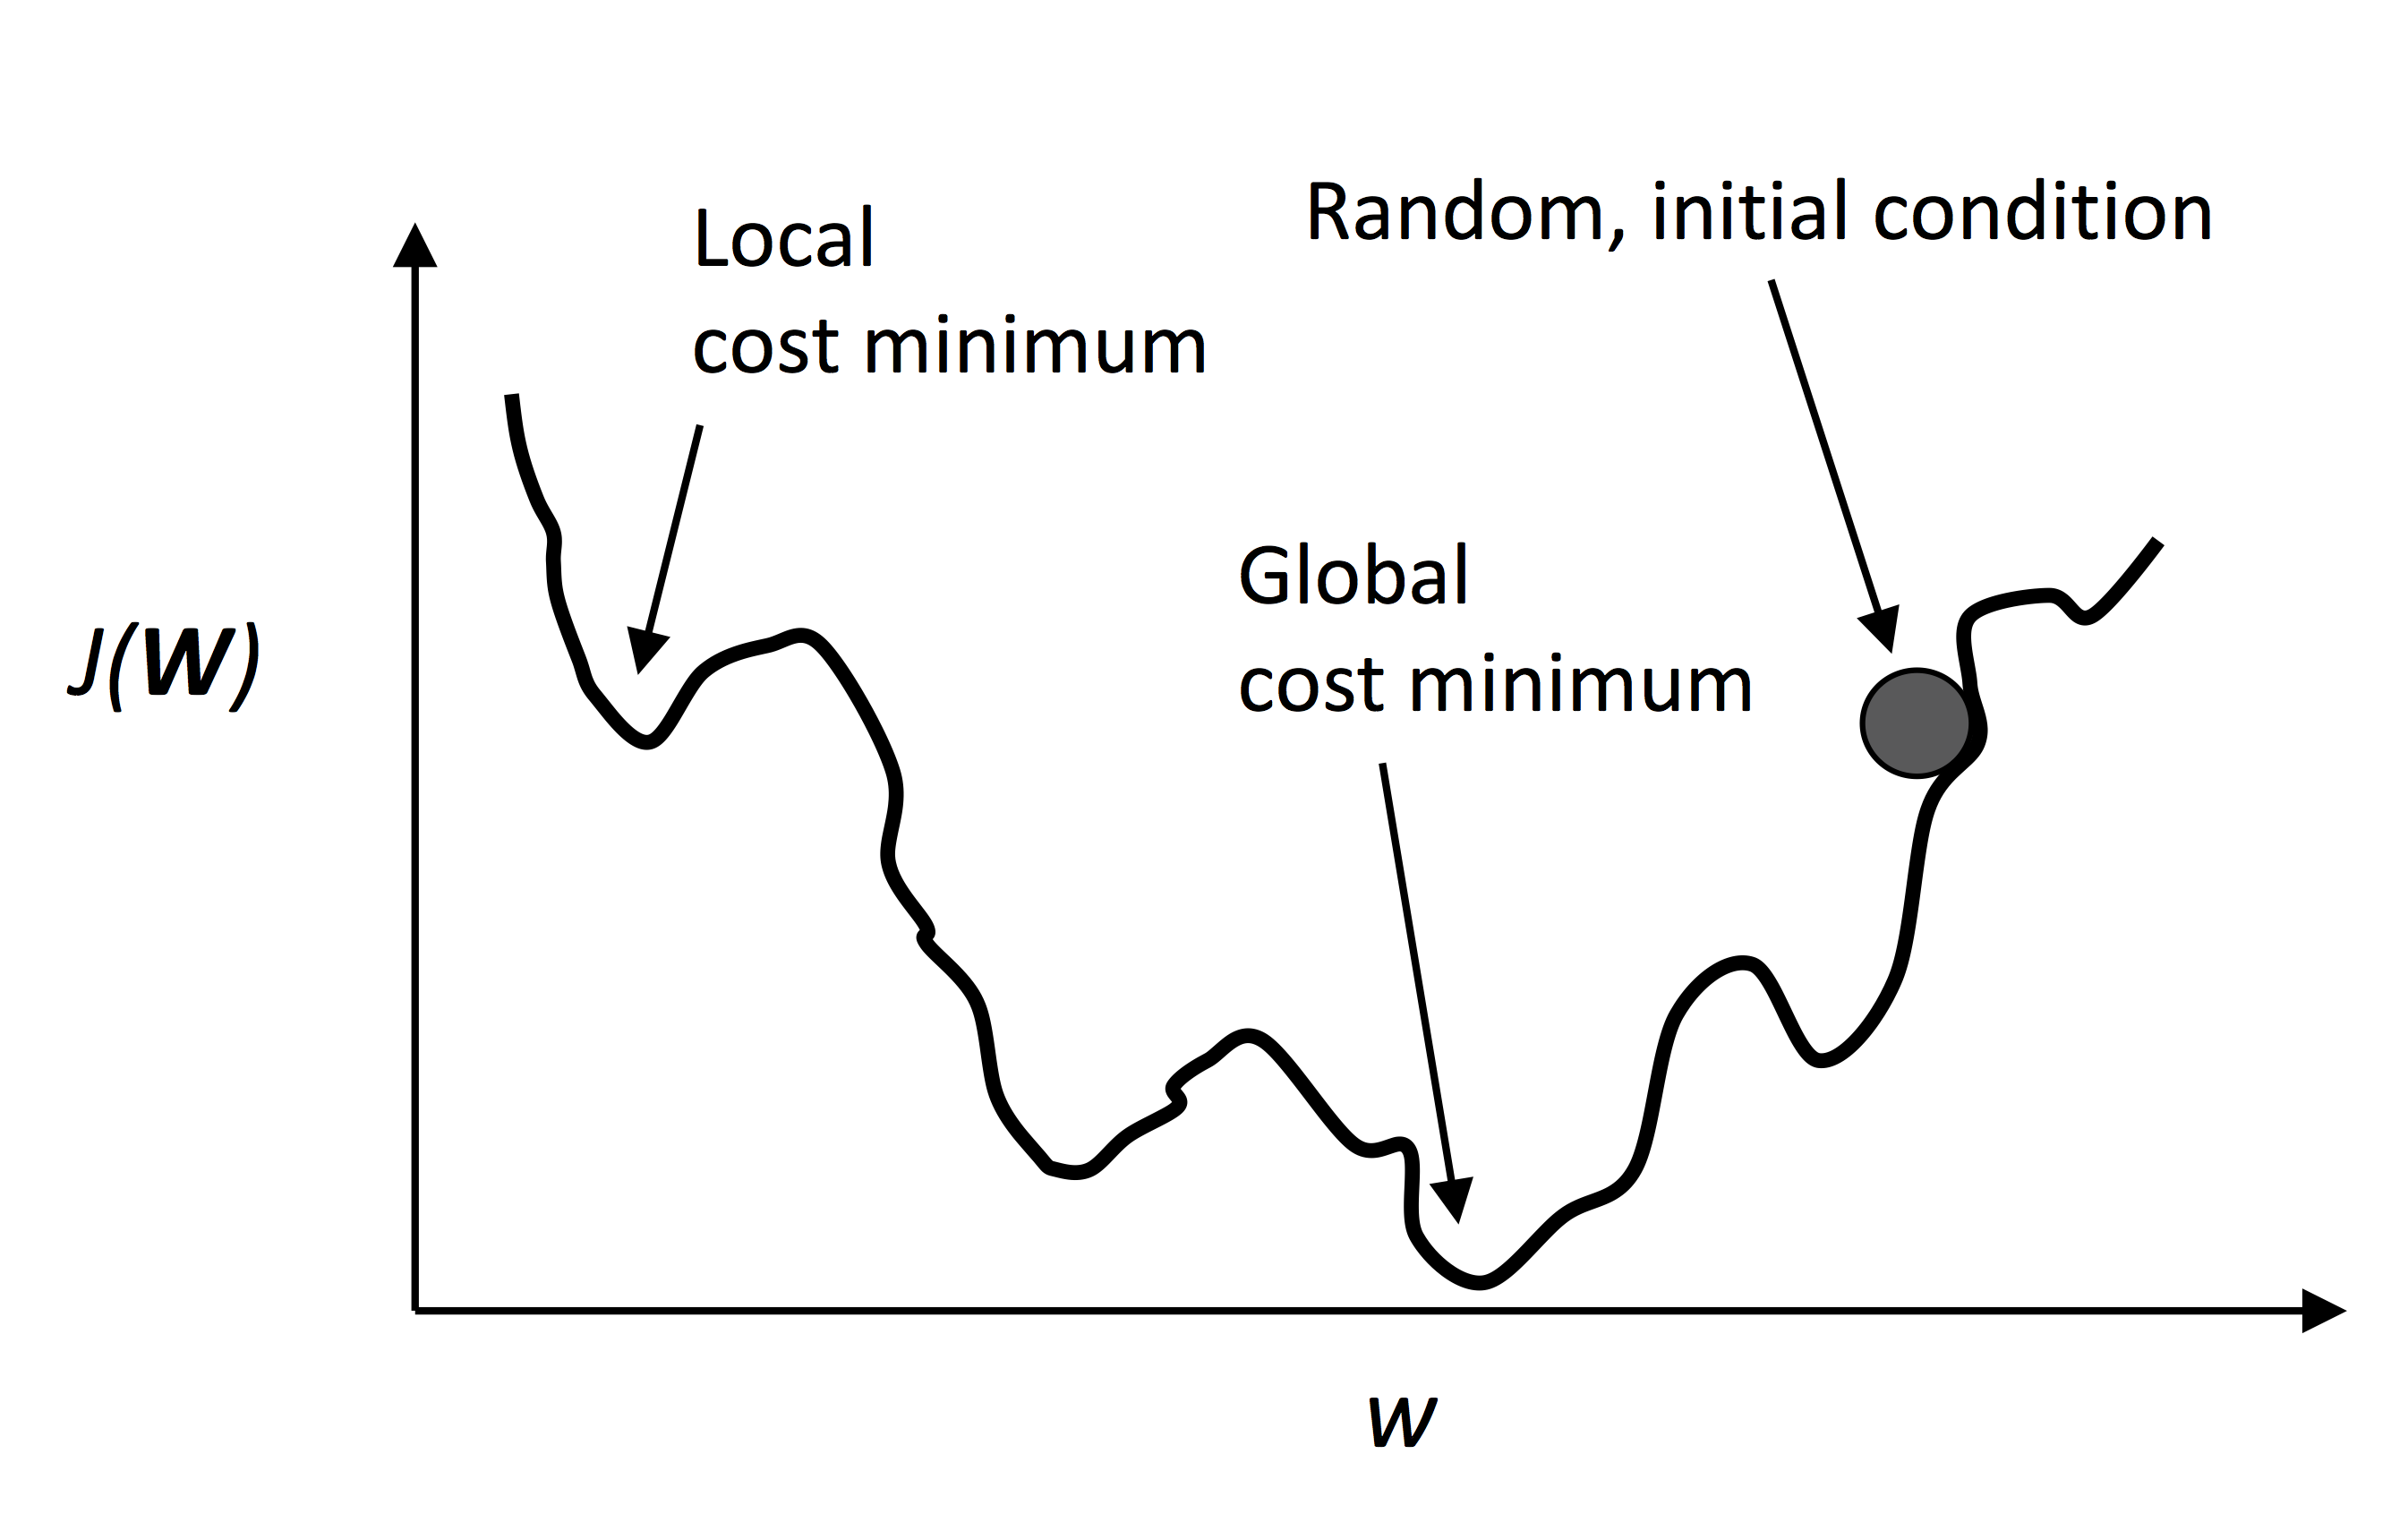

In [25]:
Image(filename='images/12_13.png', width=500) 

We used mini-batch learning to train our neural network for the handwritten digit
classification. You may recall our discussion on stochastic gradient descent that we
used to implement online learning. In online learning, we compute the gradient
based on a single training example (k = 1) at a time to perform the weight update.
Although this is a stochastic approach, it often leads to very accurate solutions
with a much faster convergence than regular gradient descent. Mini-batch learning
is a special form of stochastic gradient descent where we compute the gradient
based on a subset k of the n training samples with 1 < k < n. Mini-batch learning
has the advantage over online learning that we can make use of our vectorized
implementations to improve computational efficiency. However, we can update the
weights much faster than in regular gradient descent. Intuitively, you can think of
mini-batch learning as predicting the voter turnout of a presidential election from a
poll by asking only a representative subset of the population rather than asking the
entire population (which would be equal to running the actual election).


### Excercise:

> Write digits on a paper and check how well your network works! 
> Please prepeare the data set, e.g., by following the youtube-explanation:
> https://www.youtube.com/watch?v=iwoLAj-SZ80



In [30]:
import matplotlib.pyplot as plt
import cv2  # for handling images (reading, converting etc.

In [31]:
# load sample image
file = r'sample_1.jpg'

In [32]:
#read file
test_image = cv2.imread(file)

In [33]:
pwd

'/Users/marie-christineckert/Nextcloud/TU/Lehre/Einführung/Notebooks/Hand written Digits'

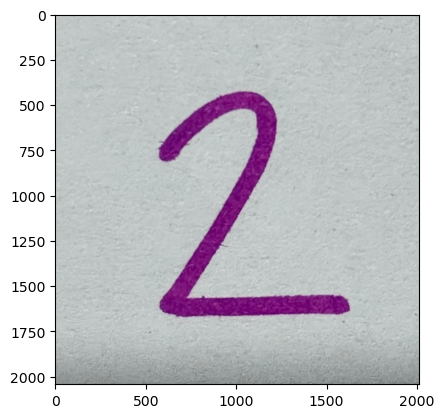

In [34]:
#plot file (colored)
plt.imshow(test_image)

In [35]:
#test_image = cv2.imread(file, cv2.IMREAD_GRAYSCALE)

grayImage = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)

In [36]:
# Format image 
img_resized = cv2.resize(grayImage, (28,28), interpolation = cv2.INTER_LINEAR)
img_resized = cv2.bitwise_not(img_resized)

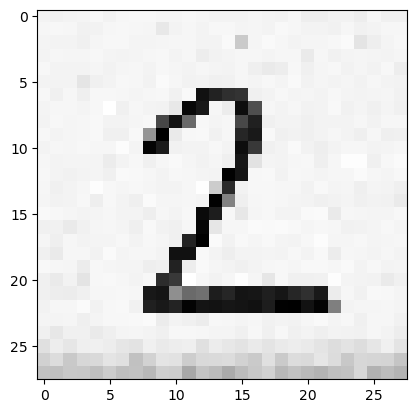

In [37]:
# Plot image
plt.imshow(img_resized, cmap='Greys', interpolation='nearest') ## Wie oben im Code! 

In [38]:
## We need to normalize the data! (see Book page 392)
test_img = ((img_resized/255.)-0.5)*2

In [39]:
# Flatten data to obtain a suitable form for prediction
test_img = test_img.flatten()

In [40]:
# As a test (you can later replace the repeating data with additional data)

x_test_img_pred = np.zeros((5,784))
x_test_img_pred[0,:] = test_img
x_test_img_pred[1,:] = test_img #save here your own sample
x_test_img_pred[2,:] = test_img #save here your own sample
x_test_img_pred[3,:] = test_img #save here your own sample
x_test_img_pred[4,:] = test_img #save here your own sample

# Predict the data:
y_test_img_pred = nn.predict(x_test_img_pred)

#x_test_img_a_pred.shape

In [41]:
y_test_img_pred

array([2, 2, 2, 2, 2])

In [42]:
x_test_img_pred.shape

(5, 784)

In [48]:

#y_true = np.array([5], dtype = int)
#y_true

In [49]:
#len(y_test)
y_test

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

## len(y_test)

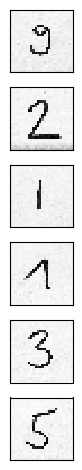

Predicted number:  [7 2 1 7 3 5] , Truth:  [9 2 1 1 3 5]


In [45]:
# the solution:

y_label_img_pred = np.array([9,2,1,1,3,5])

# number of images:
NoI = 6

x_test_img_pred = np.zeros((NoI,784))


fig, ax = plt.subplots(nrows=NoI, ncols=1, sharex=True, sharey=True,)
ax = ax.flatten()


## all in once:
for i in range(NoI):
    file = r'sample_{}.jpg'.format(i)
    
    # read file:
    test_image = cv2.imread(file)
    

    # convert to gray Image
    grayImage = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
    
    # Scale image  
    img_resized = cv2.resize(grayImage, (28,28), interpolation = cv2.INTER_LINEAR)

    # invert color
    img_resized = cv2.bitwise_not(img_resized)
    
    
    ax[i].imshow(img_resized, cmap='Greys', interpolation='nearest')
    #ax[i].set_title('%d) t: %d p: %d' % (i+1, y_label_img_pred))

       
    # Scale the data (to the interval -1,1)! (see Book page 392)
    test_img = ((img_resized/255.)-0.5)*2   
    

    # Flatten data size (28,28) --> 28*28
    test_img = test_img.flatten()
    
    x_test_img_pred[i,:] = test_img

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
    #plt.savefig('images/12_09.png', dpi=300)
plt.show()
    
y_test_img_pred = nn.predict(x_test_img_pred)

print('Predicted number: ',y_test_img_pred,', Truth: ',y_label_img_pred)
